# Dimensionality Reduction & Principal Component Analysis(PCA)

When dealing with high dimensional data, that is, dataset with many dimensions or features, there are possible issues (usually term the *curse of dimensionality*) that arises such as multicollinearity (correlation among the features causing model bias) and overfitting. Dimensionality reduction helps solve this problem. 

The basic idea of dimensionality reduction is to represent the dataset by using fewer dimension of features than in the original dataset. This can often be done through various feature selection or elimination techniques including the use of domain knowledge as well as through the use *feature extraction* techniques to create a new set of features that are a linear and non-linear transformation of the original. The **PCA** is a popular approach to feature extraction that transform the high dimensional data (many features) into lower dimension (fewer features) while retaining most of the information in the original dataset.

In what follows, I implement dimensionality reduction for both linear PCA and non-linear PCA.

**The data for this practical was obtained from the IBM cloud storage**.

#### Importing Libraries

First, lets import the librabries need for the task as shown below

In [59]:
# Surpress warnings from using older version of sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from scipy.stats import loguniform
from sklearn.decomposition import PCA,KernelPCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

## Linear PCA

For this task, I retrieve the customer dataset from the IBM cloud storage and perform a PCA

Steps involved in this analysis are:
* Loading the dataset
* Data cleaning
* Data exploration
* Variable transformation
* Data modelling and insight


### Loading the dataset

In [60]:
# Loading the dataset
data= pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/data/Cust_Segmentation.csv")

data.head() # Previewing the dataset

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2


### Data cleaning

In [103]:
# Exploring the details of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      700 non-null    int64  
 1   Age              700 non-null    int64  
 2   Edu              700 non-null    int64  
 3   Years Employed   700 non-null    int64  
 4   Income           700 non-null    int64  
 5   Card Debt        700 non-null    float64
 6   Other Debt       700 non-null    float64
 7   Defaulted        700 non-null    float64
 8   Address          700 non-null    object 
 9   DebtIncomeRatio  700 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 60.2+ KB


In [104]:
# Checking for missing values.
data.isnull().sum()

Customer Id        0
Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
Address            0
DebtIncomeRatio    0
dtype: int64

Next, I drop rows with missing values this way then don't impact the analysis, I also remove to features which are not of interest. First, I remove `Address` and `Customer Id` since we are not interest in those, I also remove `Defaulted` particularly because of the missing values it had.

In [105]:
data.dropna(inplace=True)    # to drop the row with NaN
df = data.drop(columns=['Address', 'Defaulted', 'Customer Id'])# removing the Address and Defaulted columns
df.head() # previewing our clean data


,Age,Edu,Years Employed,Income,Card Debt,Other Debt,DebtIncomeRatio
0,41,2,6,19,0.124,1.073,6.3
1,47,1,26,100,4.582,8.218,12.8
2,33,2,10,57,6.111,5.802,20.9
3,29,2,4,19,0.681,0.516,6.3
4,47,1,31,253,9.308,8.908,7.2


In [106]:
print (df.shape)

(700, 7)


In [107]:
df.dtypes # checking the data types of the features

Age                  int64
Edu                  int64
Years Employed       int64
Income               int64
Card Debt          float64
Other Debt         float64
DebtIncomeRatio    float64
dtype: object

In [108]:
# Convert to floats to ensure all features are in same data types
for col in df.columns:
    df[col] = df[col].astype(float)

df.dtypes

Age                float64
Edu                float64
Years Employed     float64
Income             float64
Card Debt          float64
Other Debt         float64
DebtIncomeRatio    float64
dtype: object

### Data  exploration 

In [109]:
df.describe() # basic descriptive statistics of the features in the dataframe

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,DebtIncomeRatio
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,34.860000,1.722857,8.388571,45.601429,1.553566,3.058196,10.260571
std,7.997342,0.928206,6.658039,36.814226,2.117196,3.287550,6.827234
min,20.000000,1.000000,0.000000,14.000000,0.012000,0.046000,0.400000
25%,29.000000,1.000000,3.000000,24.000000,0.368750,1.044000,5.000000
50%,34.000000,1.000000,7.000000,34.000000,0.855000,1.987500,8.600000
75%,40.000000,2.000000,12.000000,55.000000,1.901750,3.923250,14.125000
max,56.000000,5.000000,31.000000,446.000000,20.561000,27.034000,41.300000


Now lets check the correlation and skewness of the dataset

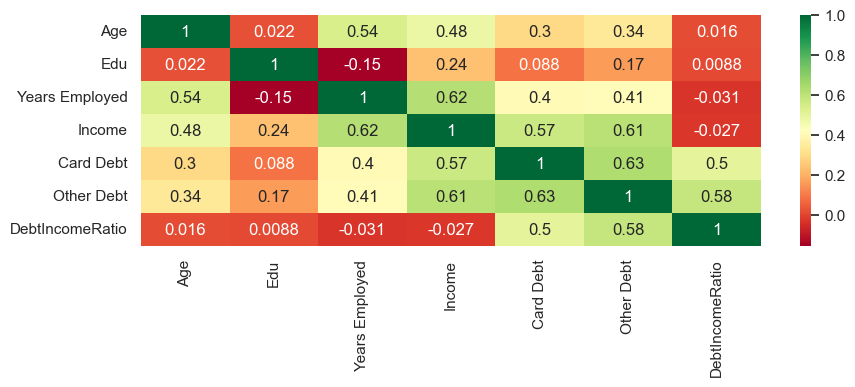

In [114]:
# plot of the correlation matrix with heatmap
plt.figure(figsize=(10,3))
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')

plt.show()

Lets view the most correlated feature for each feature 

In [115]:
# extracting the most correlated feature
corr_df = df.corr()

for x in range(corr_df.shape[0]):
    corr_df.iloc[x,x] = 0.0

corr_df.abs().idxmax()    

Age                Years Employed
Edu                        Income
Years Employed             Income
Income             Years Employed
Card Debt              Other Debt
Other Debt              Card Debt
DebtIncomeRatio        Other Debt
dtype: object

### Variable transformation

Now lets get our features to the same scale using standard scaler.

In [116]:
# Applying the standard scaler to the features
for col in df.columns:
    df[col] = StandardScaler().fit_transform(df[[col]])

df.head(5)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,DebtIncomeRatio
0,0.768304,0.298793,-0.359007,-0.723102,-0.675699,-0.604284,-0.580528
1,1.519090,-0.779325,2.647029,1.478707,1.431421,1.570620,0.372222
2,-0.232744,0.298793,0.242201,0.309845,2.154119,0.835201,1.559495
3,-0.733267,0.298793,-0.659610,-0.723102,-0.412427,-0.773833,-0.580528
4,1.519090,-0.779325,3.398538,5.637681,3.665215,1.780653,-0.448609


Now lets view the relationship between the features using pair plots

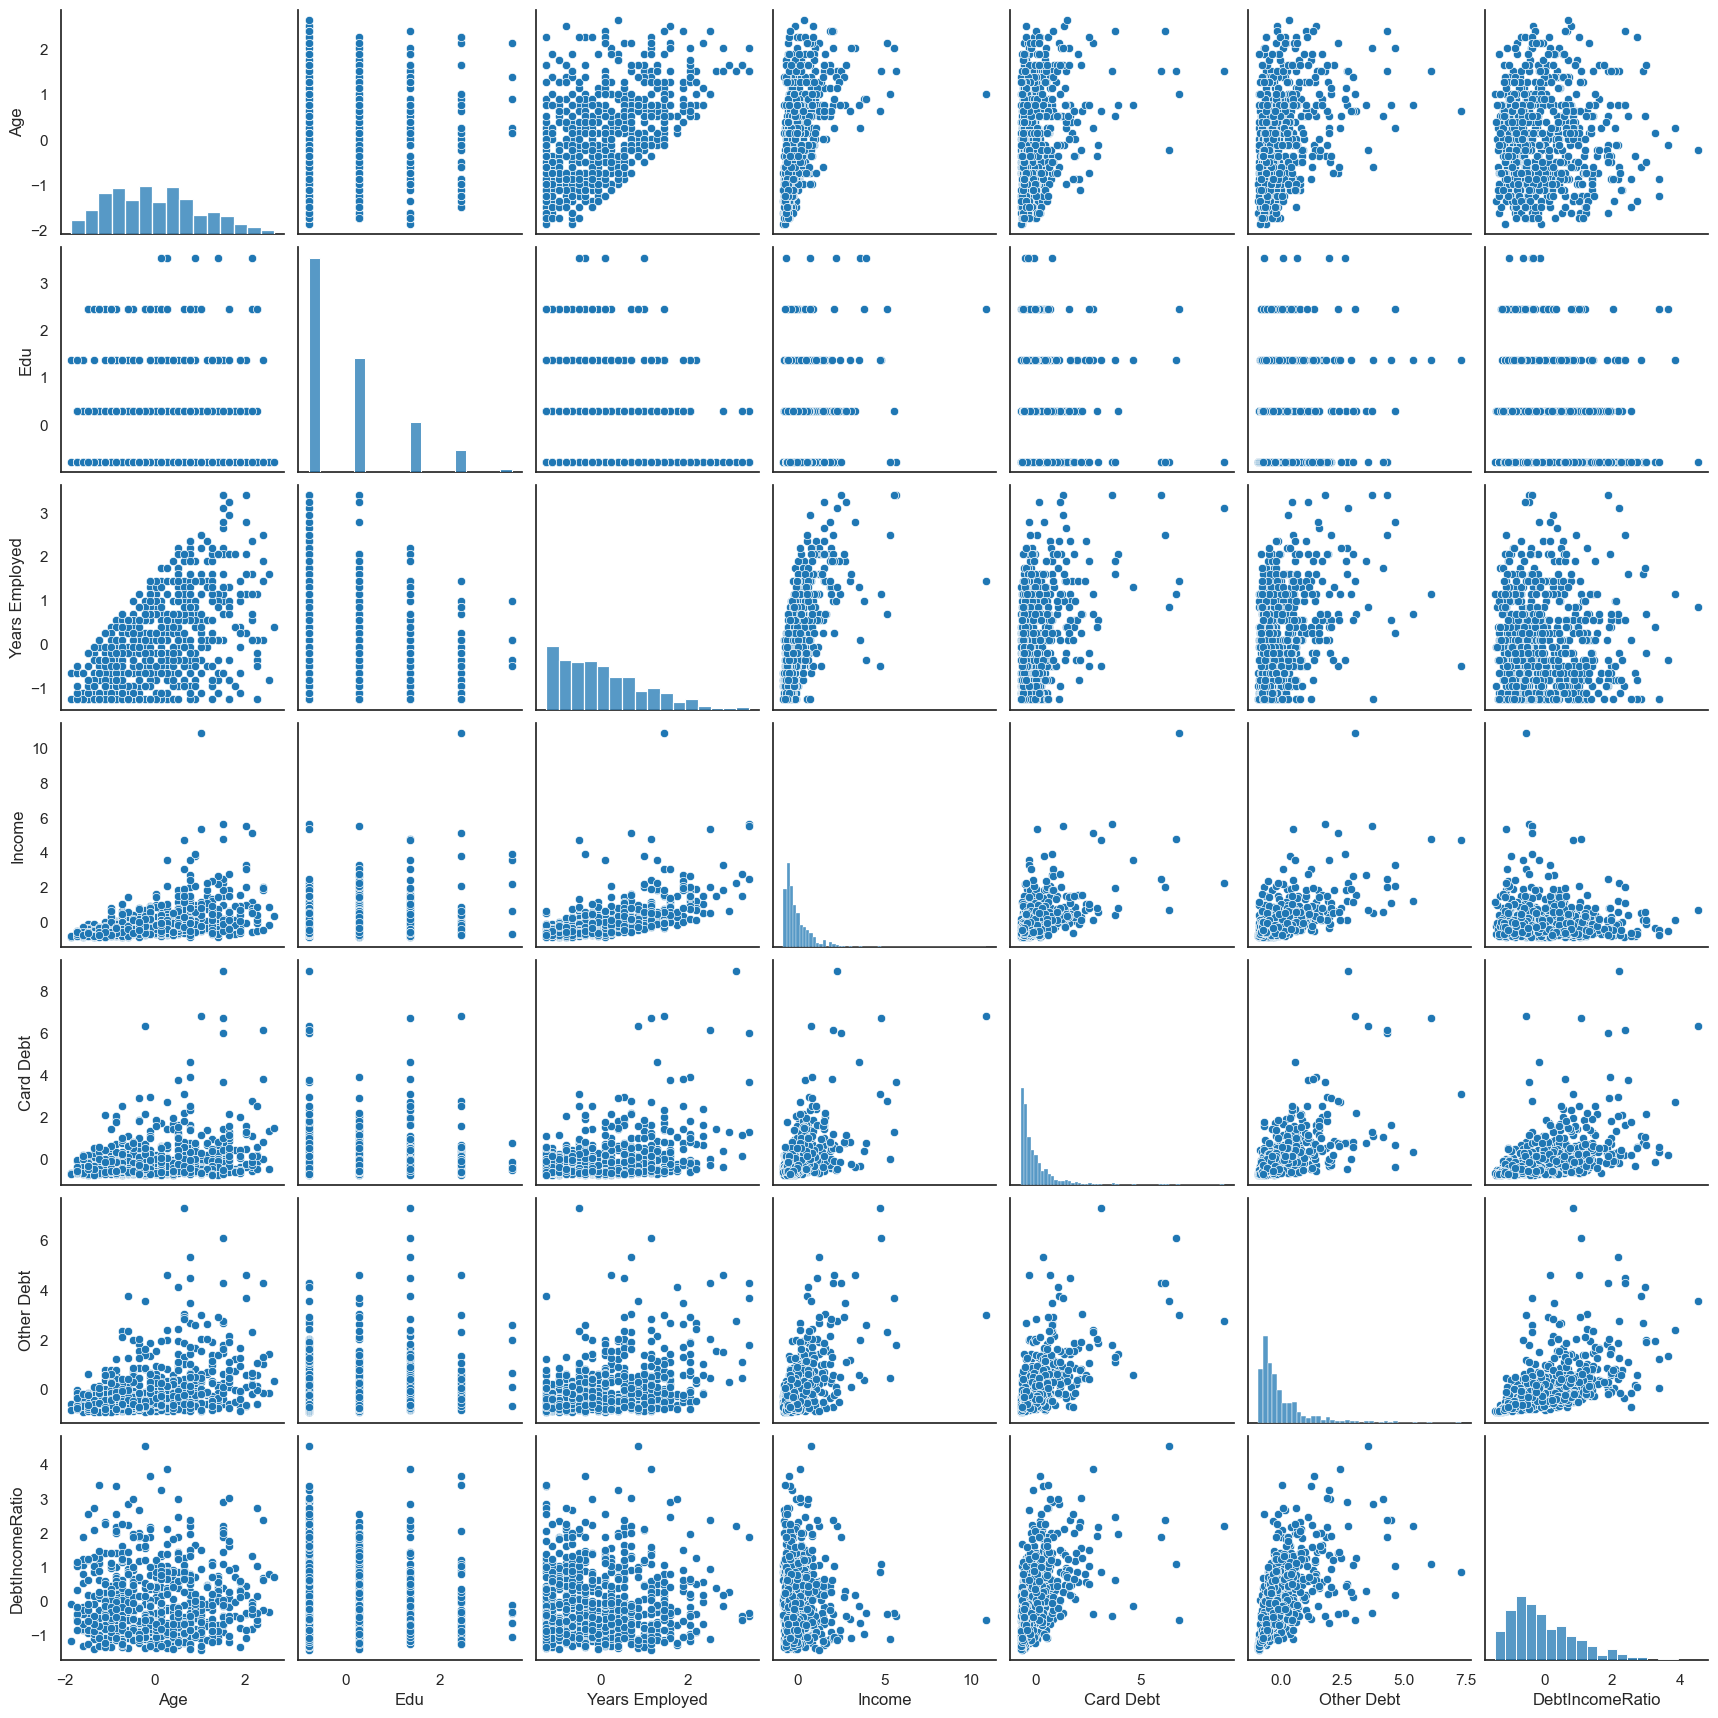

In [117]:
# pairplot for the features
sns.pairplot(df)
plt.show()

### Data modelling and insight

Now lets apply the **PCA** for all the dimensions in the original dataset, so that n_components=7

In [136]:
# Applying the PCA for all the dimensions so that n_components=7
pca = PCA()
new_data = pca.fit_transform(df)
new_data

array([[-9.17798694e-01, -6.30073759e-01,  3.34649087e-01, ...,
         1.69913668e-01, -4.07949548e-02, -2.46984204e-01],
       [ 3.70596228e+00, -1.14166317e+00, -1.17451366e+00, ...,
        -2.58137519e-01, -4.51878203e-01, -2.16749305e-01],
       [ 1.93123943e+00,  1.76502942e+00, -2.53735218e-01, ...,
         8.77856815e-01, -4.09657992e-01, -5.68766446e-02],
       ...,
       [ 3.89266374e-03,  4.02448593e+00,  1.42718871e+00, ...,
         1.72776249e-01, -1.30238810e+00,  1.10009780e+00],
       [-1.10564521e+00, -1.19858016e+00, -6.05091940e-01, ...,
        -1.77473156e-01, -2.95595256e-01, -2.55025313e-01],
       [ 1.47390961e+00, -1.61106195e+00, -8.62210406e-01, ...,
         1.65128238e-01,  1.07902701e-01, -2.85030151e-03]])

In [132]:
# Create a DataFrame from the transformed data.
column_names = [f'PC{i+1}' for i in range(new_data.shape[1])]  # Naming the columns PC1, PC2, ...

new_data = pd.DataFrame(new_data, columns=column_names)
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.917799,-0.630074,0.334649,-1.023328,0.169914,-0.040795,-0.246984
1,3.705962,-1.141663,-1.174514,0.166858,-0.258138,-0.451878,-0.216749
2,1.931239,1.765029,-0.253735,0.465666,0.877857,-0.409658,-0.056877
3,-1.527671,0.071294,0.440410,0.223128,0.233807,-0.127276,-0.193324
4,6.876019,-2.453647,-0.240697,2.610983,0.976422,0.865142,1.084995
...,...,...,...,...,...,...,...
695,-0.568460,-1.142892,-0.452411,-0.454162,0.309760,0.574569,-0.058655
696,-1.027904,-0.014187,0.432819,0.484120,-0.307162,-0.180251,-0.103405
697,0.003893,4.024486,1.427189,-0.621574,0.172776,-1.302388,1.100098
698,-1.105645,-1.198580,-0.605092,0.438867,-0.177473,-0.295595,-0.255025


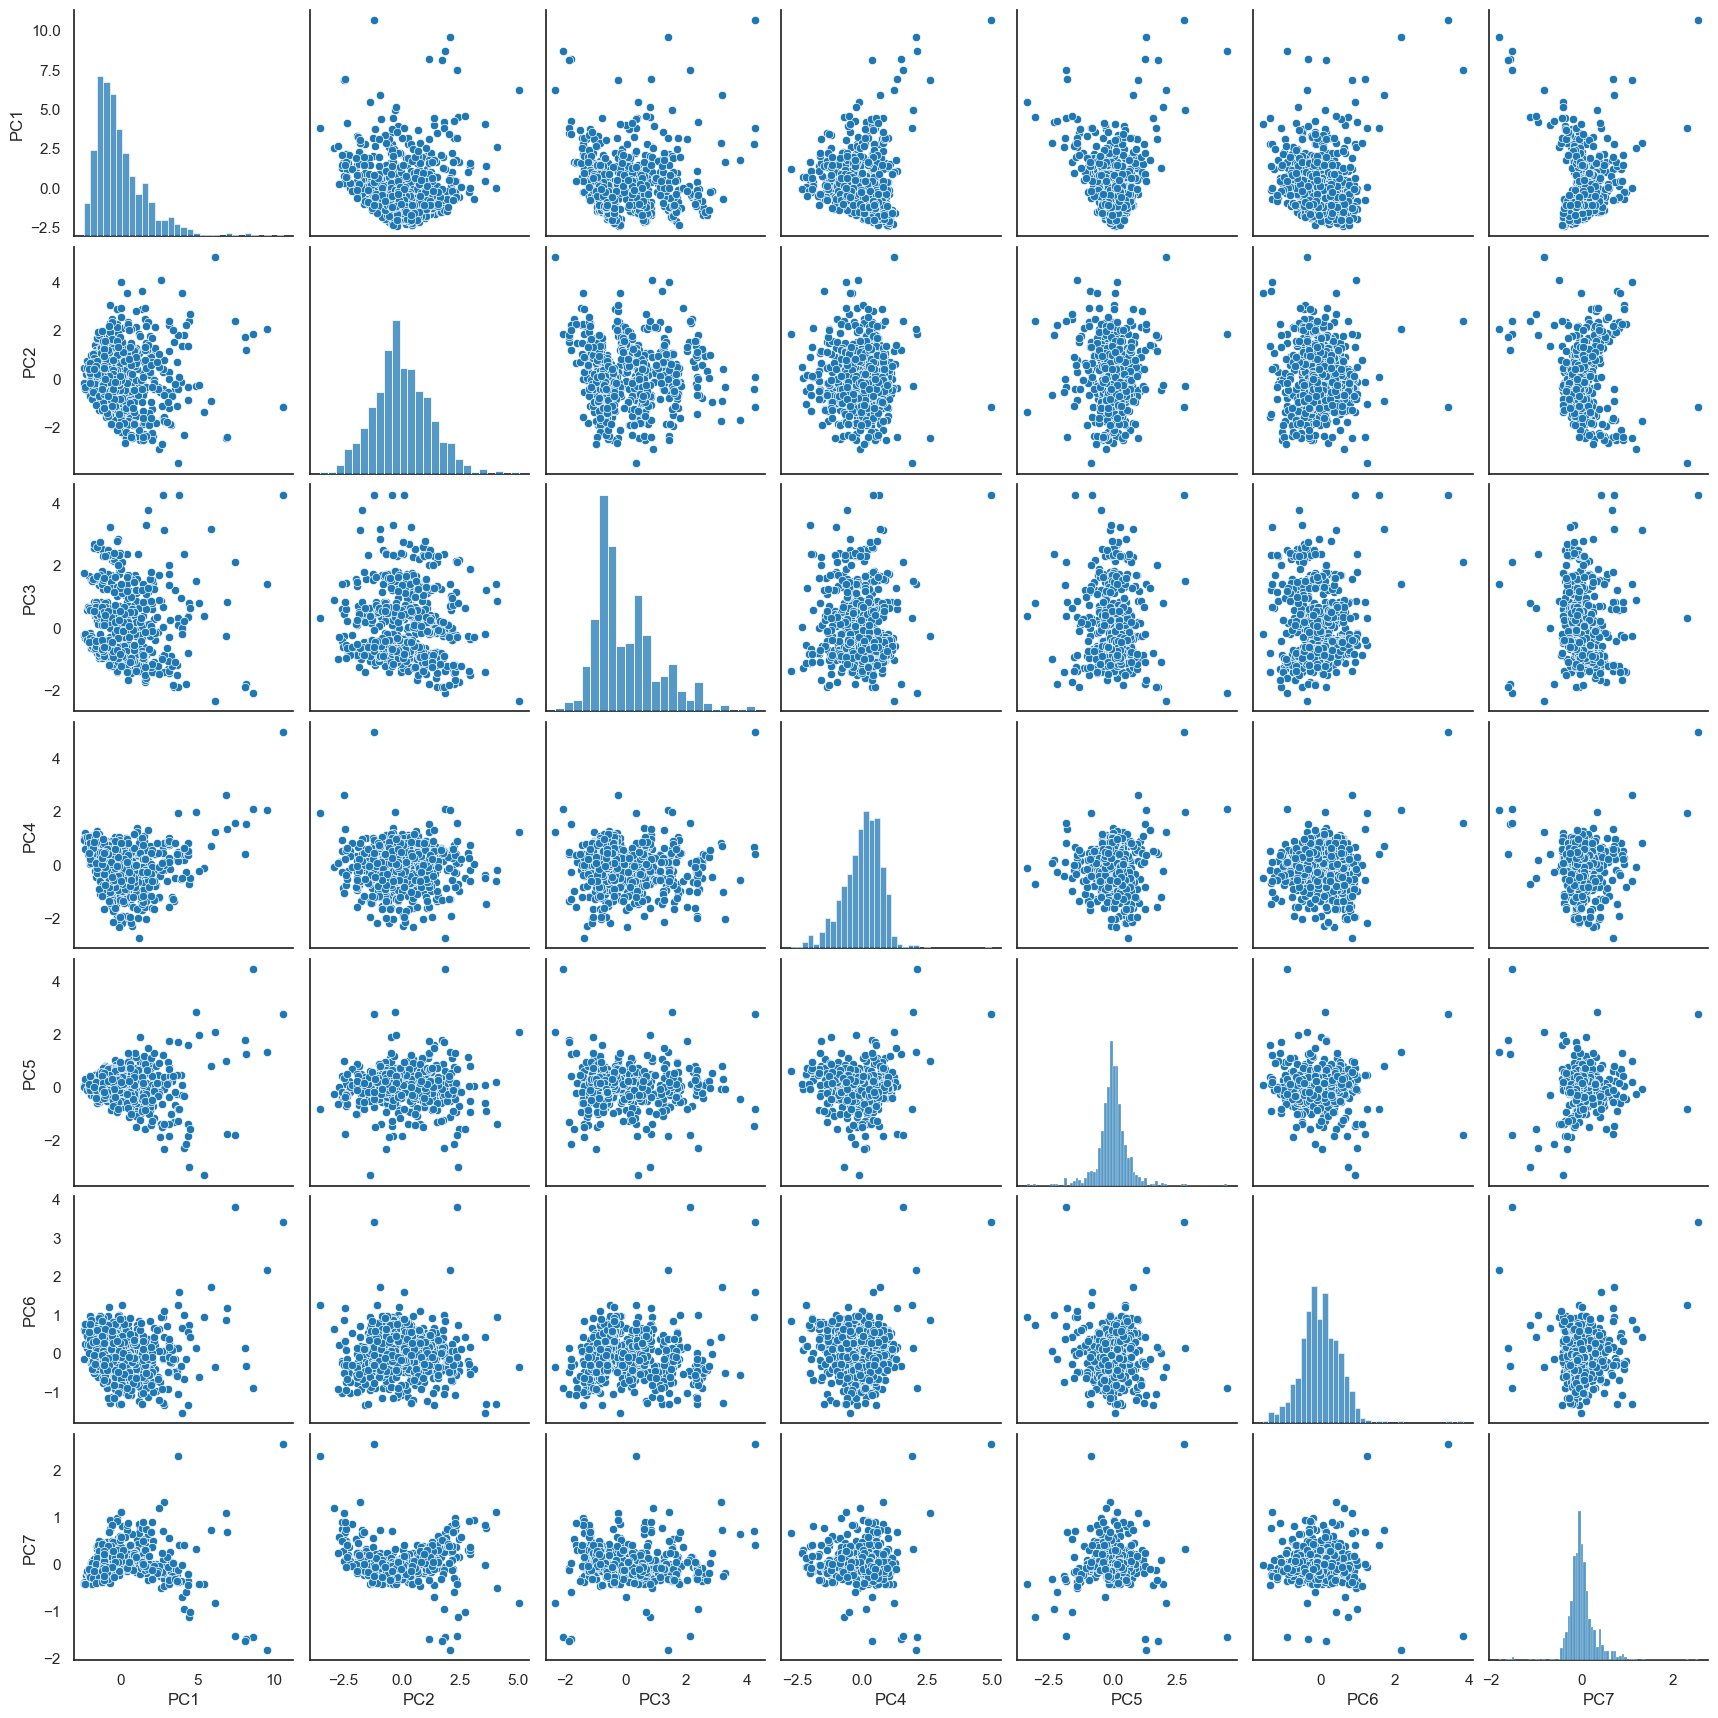

In [133]:
sns.pairplot(new_data)
plt.show()

In [119]:
# Checking the explained variance of the principal components of the PCA
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.44308299, 0.20639791, 0.15638108, 0.08345817, 0.05266822,
       0.04218158, 0.01583005])

#### On multicollinearity

Computing a correlation matirx with the `new_data` obtained from the PCA. Obsevre that unlike the previous correlation matirx, the correlations coefficient of the components are now zero, meaning we have successfully de-correlated the dataset and obtained features that are linearly independent of each other.

In [135]:
new_data.corr().style.background_gradient(cmap='RdYlGn')

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
PC1,1.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
PC2,0.000000,1.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000
PC3,-0.000000,-0.000000,1.000000,-0.000000,0.000000,-0.000000,-0.000000
PC4,-0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,-0.000000
PC5,-0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
PC6,0.000000,-0.000000,-0.000000,0.000000,0.000000,1.000000,-0.000000
PC7,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,1.000000


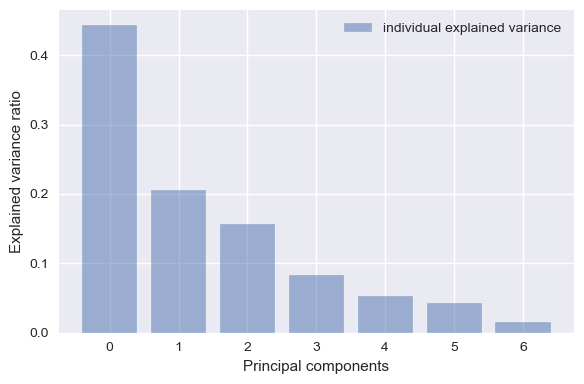

In [120]:
# Another way to view the explained variance in a graph
with plt.style.context('seaborn'):
    plt.figure(figsize=(6, 4))
    plt.bar(range(7), explained_variance, alpha=0.5, align='center', label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout() 

#### Reducing the Dimensions

In model above, I assumed used all the dimension or features in the original dataset. However if we want to select the approriate number of dimensions to reduce down to, rather than arbitrarily selecting a dimension, one way is to choose a dimension that sufficiently expain a large proportion of the variance, in this case, 90%.

I check for this in the code below.

In [121]:
# checking the number of component that will explain 90 percent of the variance.
pca = PCA()
pca.fit(df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
red_dimension = np.argmax(cumsum >=0.90) + 1
red_dimension

5

From the above output, 5 component will explain 90% of the variance. we can either plug in `n_components`= 5 or 0.90 as the proportion we want the retain in the PCA model as show below.

In [122]:
# The PCA with for 90% of the variance
pca = PCA(n_components=0.90)
pca.fit_transform(df)

array([[-9.17798694e-01, -6.30073759e-01,  3.34649087e-01,
        -1.02332777e+00,  1.69913668e-01],
       [ 3.70596228e+00, -1.14166317e+00, -1.17451366e+00,
         1.66857526e-01, -2.58137519e-01],
       [ 1.93123943e+00,  1.76502942e+00, -2.53735218e-01,
         4.65666201e-01,  8.77856815e-01],
       ...,
       [ 3.89266374e-03,  4.02448593e+00,  1.42718871e+00,
        -6.21573532e-01,  1.72776249e-01],
       [-1.10564521e+00, -1.19858016e+00, -6.05091940e-01,
         4.38867041e-01, -1.77473156e-01],
       [ 1.47390961e+00, -1.61106195e+00, -8.62210406e-01,
        -1.15243634e+00,  1.65128238e-01]])

In [123]:
# Explained variance for each of the components.
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.44308299, 0.20639791, 0.15638108, 0.08345817, 0.05266822])

# Voila!  We have now completed the PCA.

We have successfully reduced the components from 7 to 5, preserving 90 percent of the variance in the original dataset.